In [1]:
import os
import torch
import pandas as pd
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.optim import lr_scheduler
from sklearn import model_selection
from sklearn import metrics
import transformers
import tokenizers
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm.autonotebook import tqdm
import random
from sklearn.model_selection import GroupKFold,KFold,StratifiedKFold
from torch.utils.data import Dataset,DataLoader
import json
import re
import seaborn as sns

In [2]:
SEED = 42
def seed_everything(seed):
    print(f'setting everything to seed {seed}')
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

setting everything to seed 42


In [3]:
DATA_PATH = "../input/coleridgeinitiative-show-us-the-data/"
sample_submission = pd.read_csv('../input/coleridgeinitiative-show-us-the-data/sample_submission.csv')
train_files_path = '../input/coleridgeinitiative-show-us-the-data/train'
paper_test_folder = '../input/coleridgeinitiative-show-us-the-data/test'
paper_train_folder = '../input/coleridgeinitiative-show-us-the-data/train'
test_files_path = '../input/coleridgeinitiative-show-us-the-data/test'

In [4]:
def load_text(id_, root=""):
    with open(os.path.join(root, id_ + ".json")) as f:
        text = json.load(f)
    return text


def clean_text(txt):
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower()).strip()


def create_data():
    new_df = []

    for idx in tqdm(range(len(df))):
        article = load_text(df['Id'][idx], train_files_path)
        id_, pub_title, dataset_title, dataset_label, cleaned_label = df.iloc[idx]

        for i, section in enumerate(article):
            text = section['text']
            title = section['section_title']
            
            cleaned_text = clean_text(section['text'])
            
            found = cleaned_label in cleaned_text
    
            dic = {
                "id": [id_], 
                "section_id": [i],
                "pub_title": [pub_title], 
                "dataset_title": [dataset_title], 
                "dataset_label": [dataset_label], 
                "cleaned_label": [cleaned_label],
                "text": [text],
                "cleaned_text": [cleaned_text],
                "label_found": [found],
            }
            new_df.append(pd.DataFrame.from_dict(dic))
            
    return pd.concat(new_df).reset_index(drop=True)

In [5]:
df = pd.read_csv(DATA_PATH + 'train.csv')
new_df = create_data()  # Quite slow, could be sped-up with multi-processing.

  0%|          | 0/19661 [00:00<?, ?it/s]

<AxesSubplot:xlabel='label_found', ylabel='count'>

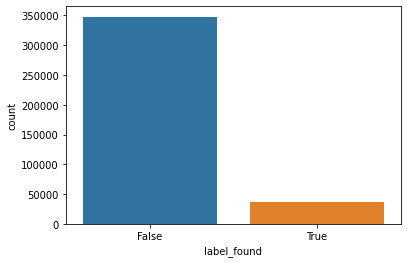

In [6]:
sns.countplot(x=new_df['label_found'])

In [7]:
df = new_df[new_df['label_found']].reset_index(drop=True)

df['length'] = df['cleaned_text'].apply(lambda x: len(x.split()))
df = df[df['length'] < 3000]  # remove too long texts

df.to_csv("df_train.csv", index=False)  # saving, just in case

In [8]:
def count_parameters(model, all=False):
    if all:
        return sum(p.numel() for p in model.parameters())
    else:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [9]:
## Literal Matching
## 训练集里面一共180个数据集标签
all_labels = set()

for label_1, label_2, label_3 in df[['dataset_title', 'dataset_label', 'cleaned_label']].itertuples(index=False):
    all_labels.add(str(label_1).lower())
    all_labels.add(str(label_2).lower())
    all_labels.add(str(label_3).lower())
    
print(f'No. different labels: {len(all_labels)}')

No. different labels: 176


In [10]:
def clean_text(txt):
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower()).strip()
def totally_clean_text(txt):
    txt = clean_text(txt)
    txt = re.sub(' +', ' ', txt)
    return txt

In [11]:
def locate_label_string(text, label):
    """
    Finds the label in the text
    """
    len_label = len(label) - 1

    candidates_idx = [i for i, e in enumerate(text) if e == label[1]]
    for idx in candidates_idx:
        if " " + text[idx: idx + len_label] == label:
            idx_start = idx
            idx_end = idx + len_label
            break

    assert (
        text[idx_start:idx_end] == label[1:]
    ), f'"{text[idx_start: idx_end]}" instead of "{label}" in "{text}"'

    char_targets = np.zeros(len(text))
    char_targets[idx_start:idx_end] = 1

    return idx_start, idx_end, char_targets


def locate_label_tokens(offsets, char_targets):
    """
    Finds the tokens corresponding to the found labels
    """
    target_idx = []
    for idx, (offset1, offset2) in enumerate(offsets):
        if sum(char_targets[offset1:offset2]) > 0:
            target_idx.append(idx)

    if not len(target_idx):
        for idx, (offset1, offset2) in enumerate(offsets):
            if sum(char_targets[offset1:offset2]) > 0:
                target_idx.append(idx)

    return target_idx[0], target_idx[-1]

In [12]:
def process_data(
    text,
    label,
    tokenizer,
    tokens,
    max_len=100,
    model_name="bert",
):

    target_start, target_end = 0, 0
    text = " " + " ".join(str(text).split())
    label = " " + " ".join(str(label).split())

    if label != " ":
        idx_start, idx_end, char_targets = locate_label_string(
            text, label
        )

    tokenized = tokenizer.encode(text)
    input_ids_text = tokenized.ids[1:-1]

    offsets = tokenized.offsets[1:-1]

    if label != " ":
        target_start, target_end = locate_label_tokens(offsets, char_targets)

    # 如果target太长，只取后半截
    if target_end >= max_len - 2:  # target is too far in the sentence, we crop its beginning.
        n_tok_to_crop = target_start - max_len // 2
        new_str_start = offsets[n_tok_to_crop][0]

        input_ids_text = input_ids_text[n_tok_to_crop:]

        offsets = [tuple(t) for t in np.array(offsets[n_tok_to_crop:]) - new_str_start]
        text = text[new_str_start:]

        target_start -= n_tok_to_crop
        target_end -= n_tok_to_crop

    input_ids = (
        [tokens["cls"]]
        + input_ids_text[:max_len - 2]
        + [tokens["sep"]]
    )

    if "roberta" in model_name:
        token_type_ids = [0] * len(input_ids)
    else:
        token_type_ids = [1] * len(input_ids)

    text_offsets = [(0, 0)] + offsets[:max_len - 2] + [(0, 0)]

    target_start += 1
    target_end += 1

    # target_end = min(target_end, max_len - 1)

    assert len(input_ids) == len(token_type_ids) and len(input_ids) == len(text_offsets), (len(input_ids), len(text_offsets))
    
    padding_length = max_len - len(input_ids)
    
    if padding_length > 0:
        input_ids = input_ids + ([tokens["pad"]] * padding_length)
        token_type_ids = token_type_ids + ([0] * padding_length)
        text_offsets = text_offsets + ([(0, 0)] * padding_length)

    return {
        "ids": input_ids,
        "token_type_ids": token_type_ids,
        "targets_start": target_start,
        "targets_end": target_end,
        "text": text,
        "label": label,
        "offsets": text_offsets,
    }

In [13]:
class ColeridgeDataset(Dataset):
    def __init__(
        self,
        df,
        tokenizer,
        max_len=512,
        model_name="bert",
    ):
        self.tokenizer = tokenizer
        self.tokens = {
            'cls': tokenizer.token_to_id('[CLS]'),
            'sep': tokenizer.token_to_id('[SEP]'),
            'pad': tokenizer.token_to_id('[PAD]'),
        }
        self.max_len = max_len
        self.model_name = model_name

        self.texts = df["cleaned_text"].values
        self.labels = df["cleaned_label"].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        data = process_data(
            self.texts[idx],
            self.labels[idx],
            self.tokenizer,
            self.tokens,
            max_len=self.max_len,
            model_name=self.model_name,
        )

        return {
            "ids": torch.tensor(data["ids"], dtype=torch.long),
            "token_type_ids": torch.tensor(data["token_type_ids"], dtype=torch.long),
            "target_start": torch.tensor(data["targets_start"], dtype=torch.long),
            "target_end": torch.tensor(data["targets_end"], dtype=torch.long),
            "text": data["text"],
            "label": data["label"],
            "offsets": torch.tensor(data["offsets"], dtype=torch.long),
        }

In [14]:
# class ColeridgeDataset:
#     def __init__(self, tweet, idx):
#         self.tweet = tweet
#         self.idx = idx
# #         self.selected_text = selected_text
#         self.tokenizer = config.TOKENIZER
#         self.max_len = config.MAX_LEN_INPUT
    
#     def __len__(self):
#         return len(self.tweet)

#     def __getitem__(self, item):
#         data = process_data(
#             self.tweet[item], 
#             self.idx[item],
# #             self.selected_text[item], 
#             self.tokenizer,
#             self.max_len
#         )
#         return {
#             'ids': torch.tensor(data["ids"], dtype=torch.long),
#             'mask': torch.tensor(data["mask"], dtype=torch.long),
# #             'token_type_ids': torch.tensor(data["token_type_ids"], dtype=torch.long),
#             'targets_start': torch.tensor(data["targets_start"], dtype=torch.long),
#             'targets_end': torch.tensor(data["targets_end"], dtype=torch.long),
#             'orig_tweet': data["orig_tweet"],
# #             'orig_selected': data["orig_selected"],
#             'offsets': torch.tensor(data["offsets"], dtype=torch.long)
#         }

In [15]:
from tokenizers import *
from transformers import *
TRANSFORMERS = {
    "roberta-base": (RobertaModel, "roberta-base"),
    'albert-base-v2': (AlbertModel, 'albert-base-v2'),
    'albert-large-v2': (AlbertModel, 'albert-large-v2'),
    'albert-xlarge-v2': (AlbertModel, 'albert-xlarge-v2'),
    'albert-xxlarge-v2': (AlbertModel, 'albert-xxlarge-v2'),
    "bert-base-uncased": (BertModel, "bert-base-uncased"),
    "bert-base-cased": (BertModel, "bert-base-cased"),
    "bert-large-uncased-whole-word-masking": (BertModel, "bert-large-uncased-whole-word-masking"),
    "distilbert-base-uncased-distilled-squad": (
        DistilBertModel,
        "distilbert-base-uncased-distilled-squad"
    )
}

class ColeridgeModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.name = model
        self.pad_idx = 1 if "roberta" in self.name else 0
        model_class, pretrained_weights = TRANSFORMERS[model]

        self.transformer = model_class.from_pretrained(
            pretrained_weights, output_hidden_states=True
        )

        self.nb_features = self.transformer.pooler.dense.out_features

        self.logits = nn.Sequential(
            nn.Linear(self.nb_features, self.nb_features),
            nn.Tanh(),
            nn.Linear(self.nb_features, 2),
        )

    def forward(self, tokens, token_type_ids):
        """
        Usual torch forward function

        Arguments:
            tokens {torch tensor} -- Sentence tokens
            token_type_ids {torch tensor} -- Sentence tokens ids
        """

        hidden_states = self.transformer(
            tokens,
            attention_mask=(tokens != self.pad_idx).long(),
            token_type_ids=token_type_ids,
        )[-1]

        features = hidden_states[-1]
        logits = self.logits(features)

        start_logits, end_logits = logits[:, :, 0], logits[:, :, 1]

        return start_logits, end_logits

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [16]:
model = ColeridgeModel('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [17]:
# class ColeridgeModel(transformers.BertPreTrainedModel):
#     def __init__(self, conf):
#         super(ColeridgeModel, self).__init__(conf)
# #         self.roberta = transformers.RobertaModel.from_pretrained(config.ROBERTA_PATH, config=conf)
#         self.bert = transformers.BertModel.from_pretrained(config.BERT_PATH, config=conf)
#         self.drop_out = nn.Dropout(0.1)
#         self.l0 = nn.Linear(768 * 2, 2)
#         torch.nn.init.normal_(self.l0.weight, std=0.02)
    
#     def forward(self, ids, mask, token_type_ids=None):
#         out = self.bert(
#             ids,
#             attention_mask=mask,
# #             token_type_ids=token_type_ids
#         )
#         out = out[2]
#         out = torch.cat((out[-1], out[-2]), dim=-1)
#         out = self.drop_out(out)
#         logits = self.l0(out)

#         start_logits, end_logits = logits.split(1, dim=-1)

#         start_logits = start_logits.squeeze(-1)
#         end_logits = end_logits.squeeze(-1)

#         return start_logits, end_logits

In [18]:
def loss_fn(start_logits, end_logits, start_positions, end_positions):
    loss_fct = nn.CrossEntropyLoss()
    start_loss = loss_fct(start_logits, start_positions)
    end_loss = loss_fct(end_logits, end_positions)
    total_loss = (start_loss + end_loss)
    return total_loss

In [19]:
def compute_fbeta(y_true,
                  y_pred,
                  beta: float = 0.5) -> float:
    """Compute the Jaccard-based micro FBeta score.

    References
    ----------
    - https://www.kaggle.com/c/coleridgeinitiative-show-us-the-data/overview/evaluation
    """

    def _jaccard_similarity(str1: str, str2: str) -> float:
        a = set(str1.split()) 
        b = set(str2.split())
        c = a.intersection(b)
        if (len(a) + len(b) - len(c))<=0:
            return 0
        return float(len(c)) / (len(a) + len(b) - len(c))

    tp = 0  # true positive
    fp = 0  # false positive
    fn = 0  # false negative
    for ground_truth_list, predicted_string_list in zip(y_true, y_pred):
        predicted_string_list_sorted = sorted(predicted_string_list)
        for ground_truth in sorted(ground_truth_list):            
            if len(predicted_string_list_sorted) == 0:
                fn += 1
            else:
                similarity_scores = [
                    _jaccard_similarity(ground_truth, predicted_string)
                    for predicted_string in predicted_string_list_sorted
                ]
                matched_idx = np.argmax(similarity_scores)
                if similarity_scores[matched_idx] >= 0.5:
                    predicted_string_list_sorted.pop(matched_idx)
                    tp += 1
                else:
                    fn += 1
        fp += len(predicted_string_list_sorted)

    tp *= (1 + beta ** 2)
    fn *= beta ** 2
    fbeta_score = tp / (tp + fp + fn)
    return fbeta_score

In [20]:
from sklearn import metrics

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [21]:
class config:
    OVERLAP = 20
    MAX_LEN = 64
    MAX_LEN_INPUT = 256
    TRAIN_BATCH_SIZE = 16
    VALID_BATCH_SIZE = 16
    EPOCHS = 5
    BERT_PATH = "../input/bert-base-uncased/"
    ROBERTA_PATH = "../input/roberta-base"
    MODEL_PATH = "model.bin"
    TRAINING_FILE = "../input/coleridgeinitiative-show-us-the-data/train.csv"
    TOKENIZER = BertWordPieceTokenizer(
        f"{BERT_PATH}/vocab.txt", 
        lowercase=True
    )

In [22]:
def trim_tensors(tokens, input_ids, model_name='bert', min_len=10):
    """
    Trim tensors so that within a batch, padding is shortened.
    This speeds up training for RNNs and Transformers

    Arguments:
        tokens {torch tensor} -- Text tokens

    Keyword Arguments:
        min_len {int} -- Minimum length to trim to (default: {10})

    Returns:
        torch tensor -- trimmed tokens
    """
    pad_token = 1 if "roberta" in model_name else 0
    max_len = max(torch.max(torch.sum((tokens != pad_token), 1)), min_len)
    return tokens[:, :max_len], input_ids[:, :max_len]

In [23]:
def train_fn(data_loader, model, optimizer, device, scheduler=None):
    model.train()
    losses = AverageMeter()
    jaccards = AverageMeter()

    tk0 = tqdm(data_loader, total=len(data_loader))
    
    for bi, d in enumerate(tk0):
        ids = d["ids"]
        token_type_ids = d['token_type_ids']
        targets_end = d["target_end"]
        targets_start = d["target_start"]
        orig_tweet = d["text"]
        label = d['label']
        offsets = d["offsets"]

        ids = ids.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        targets_start = targets_start.to(device, dtype=torch.long)
        targets_end = targets_end.to(device, dtype=torch.long)
#         offsets = offsets.to(device)

        model.zero_grad()
        
        ids, token_type_ids = trim_tensors(
                ids, token_type_ids, model.name
        )
        
        outputs_start, outputs_end = model(
            ids,
            token_type_ids
        )
            
        loss = loss_fn(outputs_start, outputs_end, targets_start, targets_end)
        loss.backward()
        optimizer.step()
        scheduler.step()

        outputs_start = torch.softmax(outputs_start, dim=1).cpu().detach().numpy()
        outputs_end = torch.softmax(outputs_end, dim=1).cpu().detach().numpy()
#         jaccard_scores = []
        
        y_true = []
        y_pred = []
        for px, tweet in enumerate(orig_tweet):
            tempoff = offsets[px].numpy()
            idx_start=np.argmax(outputs_start[px, :])
            idx_end=np.argmax(outputs_end[px, :])
            yt = []
            yp = []
            
            for kk in range(idx_start,idx_end+1):
#                 print(tempoff[kk])
                yp.append(tweet[tempoff[kk][0]:tempoff[kk][1]])
            for kk in range(targets_start[px],targets_end[px]):
#                 print(tempoff[kk])
                yt.append(tweet[tempoff[kk][0]: tempoff[kk][1]])
            y_pred.append(' '.join(yp))
            y_true.append(' '.join(yt))
        # y_true
        # y_pred
#         for px, tweet in enumerate(orig_tweet):
#             selected_tweet = orig_selected[px]
#             tweet_sentiment = sentiment[px]
#             jaccard_score, _ = calculate_jaccard_score(
#                 original_tweet=tweet,
#                 target_string=selected_tweet,
#                 sentiment_val=tweet_sentiment,
#                 idx_start=np.argmax(outputs_start[px, :]),
#                 idx_end=np.argmax(outputs_end[px, :]),
#                 offsets=offsets[px]
#             )
#             jaccard_scores.append(jaccard_score)

        jaccards.update(compute_fbeta(y_true,y_pred), ids.size(0))
        losses.update(loss.item(), ids.size(0))
        tk0.set_postfix(loss=losses.avg,jaccards=jaccards.avg)

In [24]:
def eval_fn(data_loader, model, device):
    model.eval()
    losses = AverageMeter()
    jaccards = AverageMeter()
    
    with torch.no_grad():
        tk0 = tqdm(data_loader, total=len(data_loader))
        for bi, d in enumerate(tk0):
            ids = d["ids"]
            token_type_ids = d['token_type_ids']
            targets_end = d["target_end"]
            targets_start = d["target_start"]
            orig_tweet = d["text"]
            label = d['label']
            offsets = d["offsets"]

            ids = ids.to(device, dtype=torch.long)
            token_type_ids = token_type_ids.to(device, dtype=torch.long)
            targets_start = targets_start.to(device, dtype=torch.long)
            targets_end = targets_end.to(device, dtype=torch.long)
    #         offsets = offsets.to(device)

            model.zero_grad()
        
            ids, token_type_ids = trim_tensors(
                ids, token_type_ids, model.name
            )
            outputs_start, outputs_end = model(
                ids,
                token_type_ids
            )
            
            loss = loss_fn(outputs_start, outputs_end, targets_start, targets_end)
            outputs_start = torch.softmax(outputs_start, dim=1).cpu().detach().numpy()
            outputs_end = torch.softmax(outputs_end, dim=1).cpu().detach().numpy()
            
#             jaccard_scores = []
#             for px, tweet in enumerate(orig_tweet):
#                 selected_tweet = orig_selected[px]
#                 tweet_sentiment = sentiment[px]
#                 jaccard_score, _ = calculate_jaccard_score(
#                     original_tweet=tweet,
#                     target_string=selected_tweet,
#                     sentiment_val=tweet_sentiment,
#                     idx_start=np.argmax(outputs_start[px, :]),
#                     idx_end=np.argmax(outputs_end[px, :]),
#                     offsets=offsets[px]
#                 )
#                 jaccard_scores.append(jaccard_score)

            y_true = []
            y_pred = []
            for px, tweet in enumerate(orig_tweet):
                tempoff = offsets[px].numpy()
                idx_start=np.argmax(outputs_start[px, :])
                idx_end=np.argmax(outputs_end[px, :])
                yt = []
                yp = []

                for kk in range(idx_start,idx_end+1):
    #                 print(tempoff[kk])
                    yp.append(tweet[tempoff[kk][0]:tempoff[kk][1]])
                for kk in range(targets_start[px],targets_end[px]):
    #                 print(tempoff[kk])
                    yt.append(tweet[tempoff[kk][0]: tempoff[kk][1]])
                y_pred.append(' '.join(yp))
                y_true.append(' '.join(yt))

            jaccards.update(compute_fbeta(y_true,y_pred), ids.size(0))
            losses.update(loss.item(), ids.size(0))
            tk0.set_postfix(loss=losses.avg,jaccards=jaccards.avg)
    
    print(f"Jaccard = {jaccards.avg}")
    return jaccards.avg

In [25]:
df = df.reset_index(drop=True)
df['fold'] = 0

gf = GroupKFold(5)
for i,(train_ind,val_ind) in enumerate(gf.split(df.index,groups=df.dataset_title)):
    df.loc[val_ind,'fold'] = i

<AxesSubplot:>

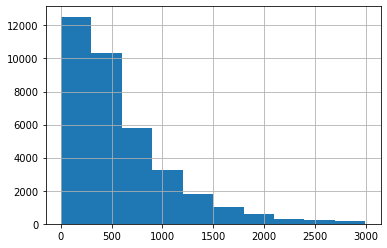

In [26]:
df.length.hist()

In [27]:
def run(fold):
#     dfx = pd.read_csv(config.TRAINING_FILE)
    tokenizer = config.TOKENIZER
    df_train = df[df.fold != fold].reset_index(drop=True)
    df_valid = df[df.fold == fold].reset_index(drop=True)
    
    
    train_dataset = ColeridgeDataset(
        df = df_train,
        tokenizer = tokenizer,
        max_len=256,
        model_name="bert-base-uncased",
    )

    train_data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config.TRAIN_BATCH_SIZE,
        num_workers=4
    )
            
    valid_dataset = ColeridgeDataset(
        df = df_valid,
        tokenizer = tokenizer,
        max_len=256,
        model_name="bert-base-uncased",
    )

    valid_data_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=config.VALID_BATCH_SIZE,
        num_workers=2
    )

    device = torch.device("cuda")
#     model_config = transformers.BertConfig.from_pretrained(config.BERT_PATH)
#     model_config.output_hidden_states = True
    model = ColeridgeModel('bert-base-uncased')
    model.to(device)

    num_train_steps = int(len(df_train) / config.TRAIN_BATCH_SIZE * config.EPOCHS)
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
    ]
    optimizer = AdamW(optimizer_parameters, lr=3e-5)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=0, 
        num_training_steps=num_train_steps
    )

#     es = utils.EarlyStopping(patience=2, mode="max")
    print(f"Training is Starting for fold={fold}")
    
    # I'm training only for 3 epochs even though I specified 5!!!
    for epoch in range(5):
        train_fn(train_data_loader, model, optimizer, device, scheduler=scheduler)
        jaccard = eval_fn(valid_data_loader, model, device)
        
        print(f"Jaccard Score = {jaccard}")
        
        state = {'model':model.state_dict()}
        
        torch.save(state, f"model_{epoch}_{fold}_{jaccard}.bin")

#         if es.early_stop:
#             print("Early stopping")
#             break

In [28]:
run(0)

Training is Starting for fold=0


  0%|          | 0/1258 [00:00<?, ?it/s]

  0%|          | 0/991 [00:00<?, ?it/s]

Jaccard = 0.11057910358924757
Jaccard Score = 0.11057910358924757


  0%|          | 0/1258 [00:00<?, ?it/s]

  0%|          | 0/991 [00:00<?, ?it/s]

Jaccard = 0.11509333874369403
Jaccard Score = 0.11509333874369403


  0%|          | 0/1258 [00:00<?, ?it/s]

  0%|          | 0/991 [00:00<?, ?it/s]

Jaccard = 0.10666190315748345
Jaccard Score = 0.10666190315748345


  0%|          | 0/1258 [00:00<?, ?it/s]

  0%|          | 0/991 [00:00<?, ?it/s]

Jaccard = 0.03342811315739434
Jaccard Score = 0.03342811315739434


  0%|          | 0/1258 [00:00<?, ?it/s]

  0%|          | 0/991 [00:00<?, ?it/s]

Jaccard = 0.06981216408579506
Jaccard Score = 0.06981216408579506


In [29]:
map_labels = {}
for word in all_labels:
    word = word.strip()
    map_labels[word] = []
    for wo in all_labels:
        wo = wo.strip()
        if wo!=word and wo in word:
            map_labels[word].append(wo)
#             already.add(wo)

# 检查出之前已经被添加过一次的
already = set()
for word in map_labels:
    word = word.strip()
    for wo in map_labels[word]:
        wo = wo.strip()
        if wo in already:
            map_labels[word].remove(wo)
        else:
            already.add(wo)

tempk = []
for k in map_labels:
    tempk += map_labels[k]
remove = []
for k in map_labels:
    if k in tempk:
        remove.append(k)

# 查看删除掉会不会漏掉
value_after_del = []

for k in map_labels:
    if k not in remove:
        value_after_del += map_labels[k]
value_after_del = set(value_after_del)
# 安全删除
for k in set(remove):
    # 查看
    for r in map_labels[k]:
        if r in value_after_del:
            map_labels[k].remove(r)
    if len(map_labels[k])==0:
        del map_labels[k]
    

def get_index(temp):  
    idxs0 = []
    idxs1 = []
    temp = temp.lower()
    already = set()
    for word in map_labels.keys():
        if word not in already:
            tempindex = temp.find(word)
            if tempindex!=-1:
                idxs0.append(tempindex)
                idxs1.append(tempindex+len(word)-1)
                already.add(word)
            else:
                # 找不到去找子集
                for wo in map_labels[word]:
                    if wo not in already:
                        tempindex = temp.find(wo)
                        if tempindex!=-1:
                            idxs0.append(tempindex)
                            idxs1.append(tempindex+len(wo)-1)
                            already.add(wo)
    #         for ind in (i for i, e in enumerate(temp) if e == word[0]):
    #             if temp[ind:ind+len_st] == word:
    #                 idx0 = ind
    #                 idx1 = ind + len_st - 1
    #                 idxs0.append(idx0)
    #                 idxs1.append(idx1)
    #                 break
    #             else:
    #                 if wo in map_labels[word]:
    #                     len_st = len(wo)
    #                     for ind in (i for i, e in enumerate(temp) if e == wo[0]):
    #                         if temp[ind:ind+len_st] == wo:
    #                             idx0 = ind
    #                             idx1 = ind + len_st - 1
    #                             idxs0.append(idx0)
    #                             idxs1.append(idx1)
    #                             break
    # 找出最长的
    mps = {}
    for k in range(len(idxs0)):
        if idxs0[k] not in mps:
            mps[idxs0[k]] = set()
        mps[idxs0[k]].add(idxs1[k])
    
    for k in mps:
        if len(mps[k])>=1:
            mps[k] = np.max(list(mps[k]))
    
    mps2 = {}
    for k in mps:
        s = mps[k]
        if s not in mps2:
            mps2[s] = set()
        mps2[s].add(k)

    for k in mps2:
        if len(mps2[k])>=1:
            mps2[k] = np.min(list(mps2[k]))
            
    
    idxs0 = []
    idxs1 = []
    for k in mps2:
        idxs1.append(k)
        idxs0.append(mps2[k])
    return {'idx0':idxs0,'idx1':idxs1}

In [30]:
def clean_paper_sentence(s):
    """
    This function is essentially clean_text without lowercasing.
    """
    s = re.sub('[^A-Za-z0-9]+', ' ', str(s)).strip()
    s = re.sub(' +', ' ', s)
    return s

def shorten_sentences(sentences):
    """
    Sentences that have more than MAX_LENGTH words will be split
    into multiple sentences with overlappings.
    """
    MAX_LENGTH = config.MAX_LEN
    short_sentences = []
    for sentence in sentences:
        words = sentence.split()
        if len(words) > MAX_LENGTH:
            for p in range(0, len(words), MAX_LENGTH - config.OVERLAP):
                short_sentences.append(' '.join(words[p:p+MAX_LENGTH]))
        else:
            short_sentences.append(sentence)
    return short_sentences

# 制作训练集
# Index(['Id', 'pub_title', 'dataset_title', 'dataset_label', 'cleaned_label'], dtype='object')

all_train_data = []
all_index = []
all_dataset = []
for paper_id in tqdm(train['Id'].unique()):
    # load paper
    temps = train[train['Id']==paper_id]
    
    paper = json.load(open(f'{paper_train_folder}/{paper_id}.json'))
    
    # extract sentences
    sentences = set([clean_paper_sentence(sentence) for section in paper 
                     for sentence in section['text'].split('.')
                    ])
    
    # 缩短句子
    sentences = shorten_sentences(sentences) # make sentences short
    
    # 筛选句子
    sentences = [sentence for sentence in sentences if len(sentence) > 10] # only accept sentences with length > 10 chars
    
    # 选出带有data，study的句子
#     sentences = [sentence for sentence in sentences if any(word in sentence.lower() for word in ['data', 'study']) or any(word in sentence.lower() for word in all_labels)]
    sentences = [sentence for sentence in sentences if any(word in sentence.lower() for word in all_labels)]

#     temps = []
#     for sentence in sentences:
#         for word in all_labels:
#             if word in sentence.lower():
#                 temps.append(sentence)
    for sentence in sentences:
        all_train_data.append(sentence)
        all_index.append(paper_id)
#     # 分词
#     sentences = [sentence.split() for sentence in sentences] # sentence = list of words
    
    
#     # mask
#     test_data = []
#     for sentence in sentences:
#         for phrase_start, phrase_end in find_mask_candidates(sentence):
#             dt_point = sentence[:phrase_start] + [mask] + sentence[phrase_end+1:]
#             test_data.append((' '.join(dt_point), ' '.join(sentence[phrase_start:phrase_end+1]))) # (masked text, phrase)
    
#     all_test_data.append(test_data)
train_data = pd.DataFrame(columns=['Id', 'sentence'])
train_data['Id'] = all_index
train_data['sentence'] = all_train_data

train_data['len'] = train_data.sentence.map(lambda x: len(x.split(" ")))
train_data['ind'] = train_data.sentence.map(get_index)
train_data['data_count'] = train_data.ind.map(lambda x: len(x['idx0']))

NameError: name 'train' is not defined